In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
br = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Bahrain%20Grand%20Prix-Race.csv")
bw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Bahrain%20Grand%20Prix-Race-weather.csv")
jr = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Japanese%20Grand%20Prix-Race.csv")
jw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Japanese%20Grand%20Prix-Race-weather.csv")
cr = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Chinese%20Grand%20Prix-Race.csv")
cw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Chinese%20Grand%20Prix-Race-weather.csv")
ar = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Australian%20Grand%20Prix-Race.csv")
aw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Australian%20Grand%20Prix-Race-weather.csv")

For the sake of simplicity, it is assumed all cars start with 110 kg of fuel, the maximum allowed, and finish the race with 0 kg of fuel, all while burning fuel at a constant rate.

As such, this allows for the fuel weight of the car on each lap to be calculated, and testing done by outside parties has concluded that each kg of fuel is approximately equivalent to a lap time loss of 0.03s. This allows for the calculation of fuel-adjusted lap times.

In addition, every car's lap 1 will be removed as they start from different positions on the grid, and thus need to travel a different distance in order to finish the first lap.

In [35]:
br = br[br['LapNumber'] != 1]
jr = jr[jr['LapNumber'] != 1]
cr = cr[cr['LapNumber'] != 1]
ar = ar[ar['LapNumber'] != 1]

In [4]:
def calculate_fuel_adjusted_time(df, total_laps):
   fuel_per_lap = 110 / total_laps
   df['FuelWeight'] = (total_laps - df['LapNumber']) * fuel_per_lap
   df['LapTime_fuel_adjusted'] = df['LapTime_in_seconds'] - (df['FuelWeight'] * 0.03)
   return df

br = calculate_fuel_adjusted_time(br, 57)
jr = calculate_fuel_adjusted_time(jr, 53)
cr = calculate_fuel_adjusted_time(cr, 56)
ar = calculate_fuel_adjusted_time(ar, 57)

In [5]:
print("BR DataFrame - Bahrain (57 laps):")
print(br[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

print("\nJR DataFrame - Japan (53 laps):")
print(jr[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

print("\nCR DataFrame - China (56 laps):")
print(cr[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

print("\nAR DataFrame - Australia (57 laps):")
print(ar[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

BR DataFrame - Bahrain (57 laps):
   LapNumber  LapTime_in_seconds  FuelWeight  LapTime_fuel_adjusted
1        2.0              97.492  106.140351              94.307789
2        3.0              98.083  104.210526              94.956684
3        4.0              98.133  102.280702              95.064579
4        5.0              98.043  100.350877              95.032474

JR DataFrame - Japan (53 laps):
   LapNumber  LapTime_in_seconds  FuelWeight  LapTime_fuel_adjusted
1        2.0              93.943  105.849057              90.767528
2        3.0              93.639  103.773585              90.525792
3        4.0              93.744  101.698113              90.693057
4        5.0              93.776   99.622642              90.787321

CR DataFrame - China (56 laps):
   LapNumber  LapTime_in_seconds  FuelWeight  LapTime_fuel_adjusted
1        2.0              97.551  106.071429              94.368857
2        3.0              97.689  104.107143              94.565786
3        4.0    

During the race, drivers may make mistakes, suffer from lock up, spin out, or run into other obstacles that may impede their driving. As such, only the lap times within 5% of the fastest lap are being kept, in order to remove potential outliers. As Australia was a rainy race, this percentage will be increased to 15% to account for the larger range of lap times due to changing track conditions.

In [6]:
def filter_lap_times_within_5_percent(df):
   fastest_lap = df['LapTime_fuel_adjusted'].min()
   threshold = fastest_lap * 1.05
   return df[df['LapTime_fuel_adjusted'] <= threshold]

def filter_lap_times_within_15_percent(df):
   fastest_lap = df['LapTime_fuel_adjusted'].min()
   threshold = fastest_lap * 1.15
   return df[df['LapTime_fuel_adjusted'] <= threshold]

brf = filter_lap_times_within_5_percent(br)
jrf = filter_lap_times_within_5_percent(jr)
crf = filter_lap_times_within_5_percent(cr)
arf = filter_lap_times_within_15_percent(ar)

print(f"Bahrain: {len(brf)} out of {len(br)} laps within 5% of fastest")
print(f"Japan: {len(jrf)} out of {len(jr)} laps within 5% of fastest")
print(f"China: {len(crf)} out of {len(cr)} laps within 5% of fastest")
print(f"Australia: {len(arf)} out of {len(ar)} laps within 15% of fastest")

Bahrain: 921 out of 1108 laps within 5% of fastest
Japan: 1002 out of 1039 laps within 5% of fastest
China: 989 out of 1045 laps within 5% of fastest
Australia: 527 out of 907 laps within 15% of fastest


We also want to remove the laps that were driven on tires that had been previously used, i.e. tires that are not fresh.

In [7]:
brf = brf[brf["FreshTyre"] == True]
jrf = jrf[jrf["FreshTyre"] == True]
crf = crf[crf["FreshTyre"] == True]
arf = arf[arf["FreshTyre"] == True]

In [8]:
def plot_tire_degradation_by_compound(df, title_prefix):
    compounds = df["Compound"].unique()
    colors = plt.cm.tab10.colors

    # Standardize axes
    x_min = df["TyreLife"].min()
    x_max = df["TyreLife"].max()
    y_min = df["LapTime_fuel_adjusted"].min()
    y_max = df["LapTime_fuel_adjusted"].max()

    plt.figure(figsize=(15, 6))

    for i, compound in enumerate(compounds):
        subset = df[df["Compound"] == compound]
        x = subset["TyreLife"]
        y = subset["LapTime_fuel_adjusted"]

        plt.subplot(1, len(compounds), i + 1)
        plt.scatter(x, y, label=compound, color=colors[i % len(colors)], alpha=0.6)

        plt.xlabel("Tire Life")
        plt.ylabel("Lap Adjusted Time")
        plt.title(f"{title_prefix}: {compound}")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.tight_layout()

    plt.show()

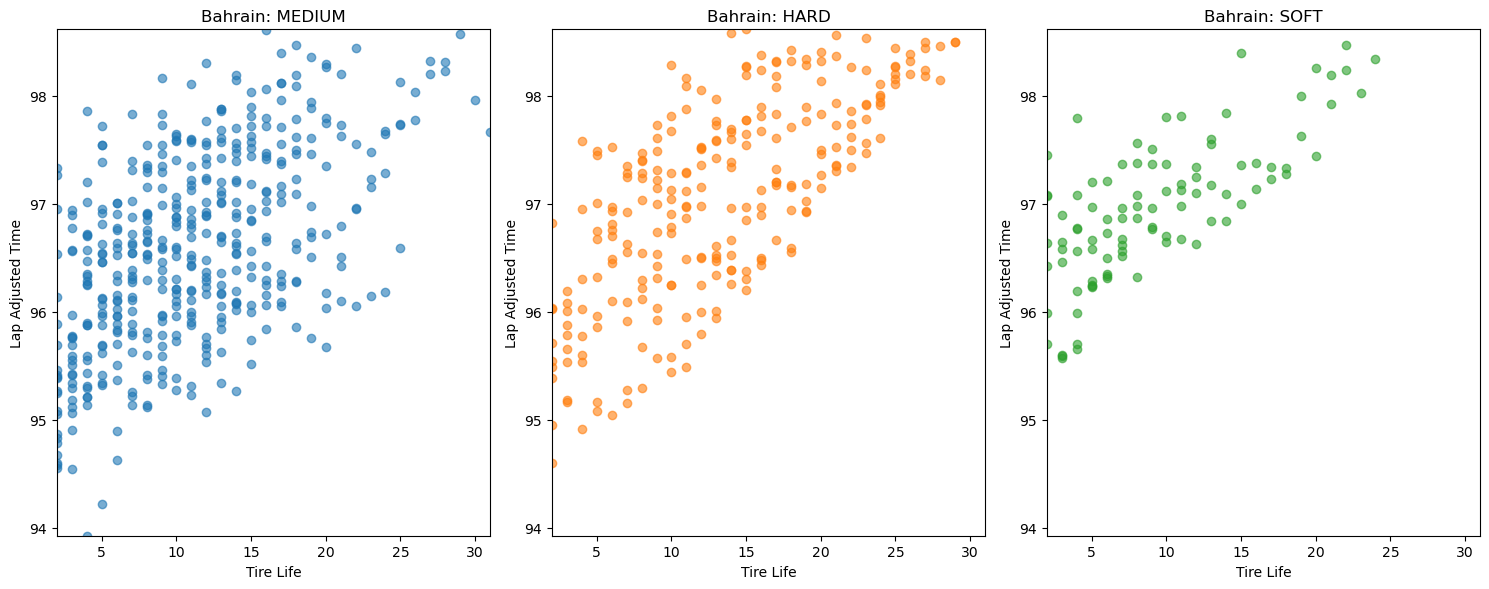

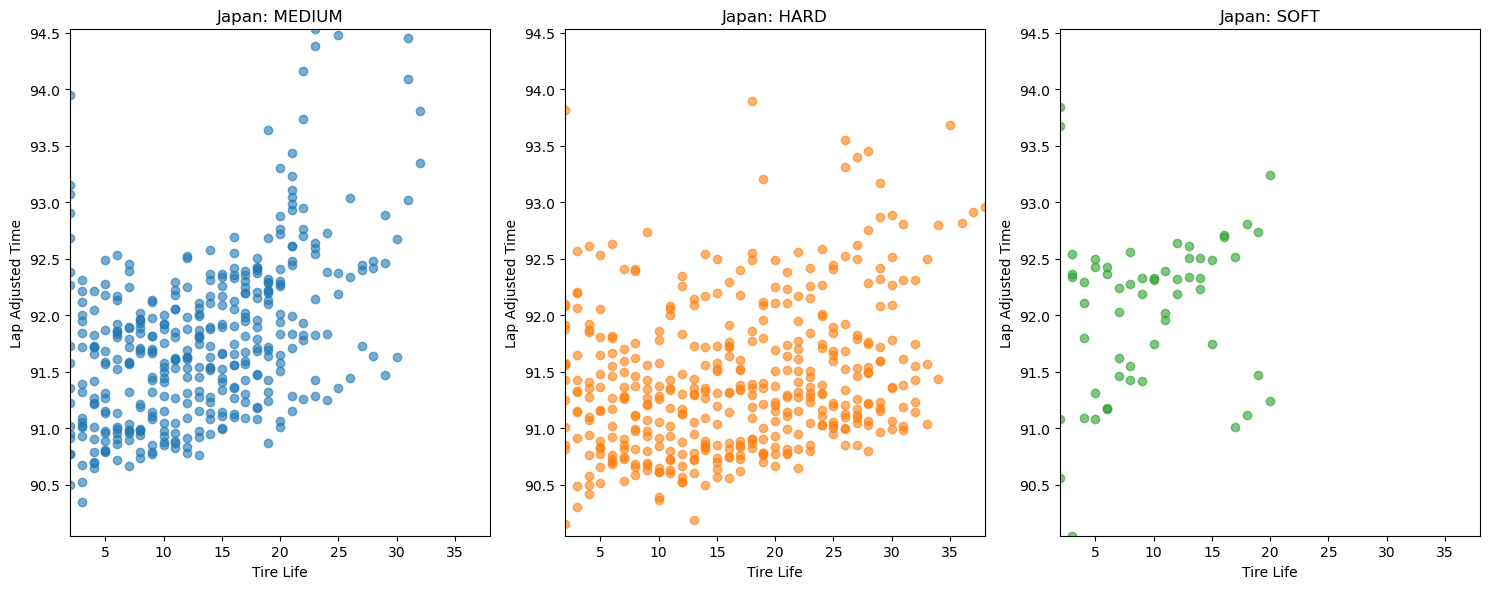

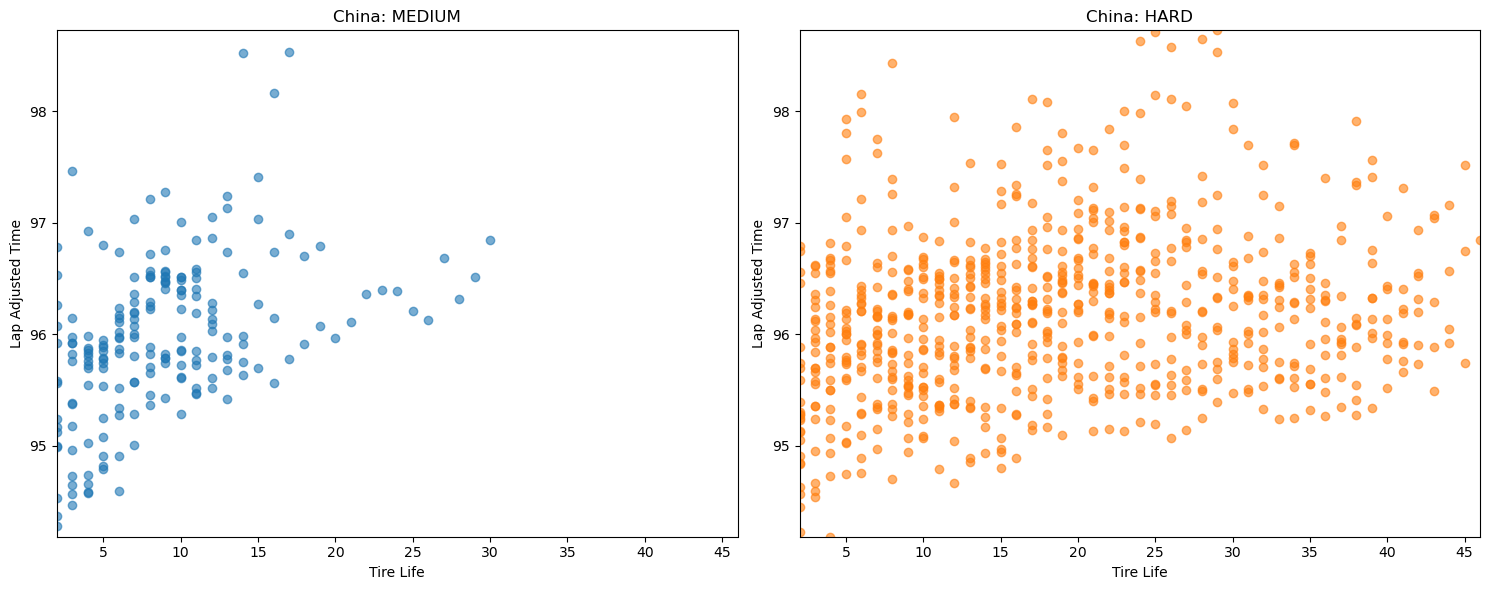

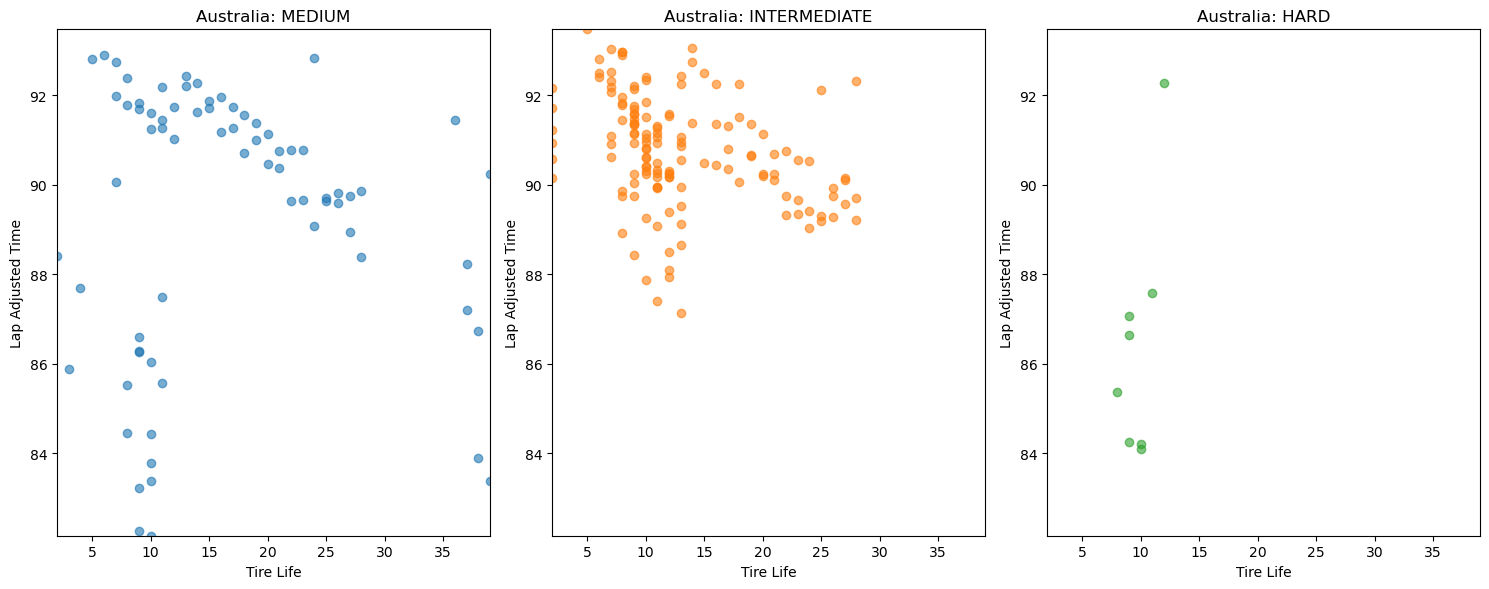

In [9]:
plot_tire_degradation_by_compound(brf, "Bahrain")
plot_tire_degradation_by_compound(jrf, "Japan")
plot_tire_degradation_by_compound(crf, "China")
plot_tire_degradation_by_compound(arf, "Australia")

Unfortunately, it seems like the data from the Australian GP was just not particularly telling, as drivers were unable to find consistent lap times in the rain. As such, only the other three races will be used from this point onwards.

During the race, drivers need to make pit stops in order to change tires. The average pit stop duration for each race will need to be calculated, since the length of the pits is not uniform across all races.

In [10]:
def compute_average_pit_stop_duration(df):
    # Convert columns to Timedelta (only if they’re not already)
    df = df.copy()
    df["PitInTime"] = pd.to_timedelta(df["PitInTime"], errors="coerce")
    df["PitOutTime"] = pd.to_timedelta(df["PitOutTime"], errors="coerce")

    durations = []

    for i in range(len(df) - 1):
        pit_in = df.iloc[i]["PitInTime"]
        pit_out = df.iloc[i + 1]["PitOutTime"]

        if pd.notna(pit_in) and pd.notna(pit_out):
            duration = (pit_out - pit_in).total_seconds()
            if duration > 0:
                durations.append(duration)

    return sum(durations) / len(durations) if durations else None


# Compute for each race
br_avg = compute_average_pit_stop_duration(br)
jr_avg = compute_average_pit_stop_duration(jr)
cr_avg = compute_average_pit_stop_duration(cr)

print(f"Bahrain average pit stop duration: {br_avg:.2f} seconds")
print(f"Japan average pit stop duration: {jr_avg:.2f} seconds")
print(f"China average pit stop duration: {cr_avg:.2f} seconds")


Bahrain average pit stop duration: 25.27 seconds
Japan average pit stop duration: 23.81 seconds
China average pit stop duration: 23.35 seconds


A MLP will now be used in order to identify the relationship between tire compound, tire life, and lap time; this relationship will be used to simulate entire races and figure out optimal pit strategy.

In [26]:
import torch
from typing import List, Tuple, Dict

class F1LapTimePredictor:
    """Model to predict lap times based on tire life and compound"""
    
    def __init__(self):
        """Initialize the lap time predictor"""
        self.lap_time_models = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.compounds = None
        self.data = None
        
    def train(self, df):
        """
        Train models to predict lap time based on tire life for each compound.
        
        Args:
            df: DataFrame containing race data with LapTime_fuel_adjusted, TyreLife, and Compound columns
        """
        self.data = df
        self.compounds = df['Compound'].unique()
        print(f"Training models for compounds: {self.compounds}")
        
        for compound in self.compounds:
            compound_data = df[df['Compound'] == compound]
            
            if len(compound_data) < 5:  # Skip if not enough data
                print(f"Not enough data for compound {compound}, skipping model training")
                continue
                
            X = torch.tensor(compound_data['TyreLife'].values, dtype=torch.float32).reshape(-1, 1).to(self.device)
            y = torch.tensor(compound_data['LapTime_fuel_adjusted'].values, dtype=torch.float32).to(self.device)
            
            # Create a simple neural network model
            model = torch.nn.Sequential(
                torch.nn.Linear(1, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 1)
            ).to(self.device)

            
            # Train the model
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
            loss_fn = torch.nn.MSELoss()
            
            epochs = 1000
            for epoch in range(epochs):
                optimizer.zero_grad()
                y_pred = model(X)
                loss = loss_fn(y_pred, y.reshape(-1, 1))
                loss.backward()
                optimizer.step()
                
                if (epoch + 1) % 200 == 0:
                    print(f"Compound {compound} - Epoch {epoch+1}, Loss: {loss.item():.4f}")
            
            self.lap_time_models[compound] = model
    
    def predict(self, compound: str, tire_life: int) -> float:
        """
        Predict lap time for a given compound and tire life.
        
        Args:
            compound: Tire compound
            tire_life: Current life of the tire in laps
            
        Returns:
            Predicted lap time in seconds
        """
        if compound not in self.lap_time_models:
            # If no model exists, use the average lap time for this compound
            compound_data = self.data[self.data['Compound'] == compound]
            if len(compound_data) > 0:
                return compound_data['LapTime_fuel_adjusted'].mean()
            else:
                # If no data, use overall average
                return self.data['LapTime_fuel_adjusted'].mean()
        
        model = self.lap_time_models[compound]
        tire_life_tensor = torch.tensor([[tire_life]], dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predicted_time = model(tire_life_tensor).item()
        
        return predicted_time
    
    def visualize_predictions(self, title_prefix="Tire Degradation"):
        """
        Visualize actual data points and model predictions for each compound.
        
        Args:
            title_prefix: Prefix for the plot title
        """
        compounds = self.compounds
        colors = plt.cm.tab10.colors

        # Standardize axes
        x_min = self.data["TyreLife"].min()
        x_max = self.data["TyreLife"].max()
        y_min = self.data["LapTime_fuel_adjusted"].min()
        y_max = self.data["LapTime_fuel_adjusted"].max()

        plt.figure(figsize=(15, 6))

        for i, compound in enumerate(compounds):
            subset = self.data[self.data["Compound"] == compound]
            x_actual = subset["TyreLife"]
            y_actual = subset["LapTime_fuel_adjusted"]

            plt.subplot(1, len(compounds), i + 1)
            plt.scatter(x_actual, y_actual, label=f"{compound} Actual", 
                      color=colors[i % len(colors)], alpha=0.6)

            # Add model predictions if model exists
            if compound in self.lap_time_models:
                x_pred = np.linspace(x_min, x_max, 100)
                y_pred = [self.predict(compound, x) for x in x_pred]
                plt.plot(x_pred, y_pred, label=f"{compound} Predicted", 
                       color=colors[i % len(colors)], linewidth=2)

            plt.xlabel("Tire Life")
            plt.ylabel("Lap Time (seconds)")
            plt.title(f"{title_prefix}: {compound}")
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

        plt.show()

In [38]:
import itertools

class F1RaceSimulator:
    """Simulate F1 races with different pit strategies"""
    
    def __init__(self, lap_time_predictor, total_laps: int, track_code: str):
        """
        Initialize the race simulator.
        
        Args:
            lap_time_predictor: Trained F1LapTimePredictor instance
            total_laps: Total number of laps in the race
            track_code: Track code (br, jr, cr, etc.)
        """
        self.predictor = lap_time_predictor
        self.total_laps = total_laps
        
        # Make sure track_code is a string, not a DataFrame
        if hasattr(track_code, 'upper'):
            self.track_code = track_code
        else:
            # If it's not a string (likely a DataFrame), set a default
            print("Warning: track_code is not a string. Using 'unknown' as default.")
            self.track_code = "unknown"
        
        # Set pit time penalty based on track code
        if self.track_code == "br":
            self.pit_time_penalty = 25.27  # Bahrain
        elif self.track_code == "jr":
            self.pit_time_penalty = 23.81  # Japan
        elif self.track_code == "cr":
            self.pit_time_penalty = 23.35  # China
        else:
            self.pit_time_penalty = 24.0  # Default value
            
        print(f"Using pit stop time penalty for {self.track_code.upper()}: {self.pit_time_penalty:.2f}s")
        
        # Constants for fuel weight calculation
        self.initial_fuel = 110.0  # kg, maximum allowed
        self.fuel_time_penalty = 0.03  # seconds per kg of fuel
    
    def calculate_fuel_weight(self, lap: int) -> float:
        """
        Calculate the fuel weight at a given lap.
        
        Args:
            lap: Current lap number
            
        Returns:
            Fuel weight in kg
        """
        fuel_burn_per_lap = self.initial_fuel / self.total_laps
        remaining_fuel = self.initial_fuel - (lap - 1) * fuel_burn_per_lap
        return max(0, remaining_fuel)
    
    def simulate_strategy(self, pit_laps: List[int], compounds: List[str]) -> Tuple[float, List[float]]:
        """
        Simulate a race with given pit strategy and return total race time.
        
        Args:
            pit_laps: List of lap numbers to pit at
            compounds: List of compounds to use (including starting compound)
            
        Returns:
            Tuple of (total_race_time, lap_times_list)
        """
        if len(pit_laps) != len(compounds) - 1:
            raise ValueError("Number of pit stops must be one less than number of compounds")
        
        total_time = 0
        current_compound = compounds[0]
        tire_life = 1  # Start with tire life = 1 (lap 1 doesn't count)
        compound_index = 0
        lap_times = []

        for lap in range(1, self.total_laps + 1):
            # Skip lap 1 in timing calculations as mentioned in the requirements
            if lap == 1:
                # Still increase tire life and fuel usage
                continue

            # Calculate fuel weight impact on lap time
            fuel_weight = self.calculate_fuel_weight(lap)
            fuel_penalty = fuel_weight * self.fuel_time_penalty

            # Check if we need to pit
            if lap in pit_laps:
                # Add pit stop time
                total_time += self.pit_time_penalty

                # Switch to new compound and reset tire life to 1
                compound_index += 1
                current_compound = compounds[compound_index]
                tire_life = 1  # 🔧 This is the key fix

            # Predict base lap time
            base_lap_time = self.predictor.predict(current_compound, tire_life)

            # Add fuel-adjusted lap time
            lap_time = base_lap_time + fuel_penalty
            total_time += lap_time
            lap_times.append(lap_time)

            # Increment tire life for next lap
            tire_life += 1

        return total_time, lap_times


    
    def format_race_time(self, seconds: float) -> str:
        """
        Format race time in hours:minutes:seconds.milliseconds
        
        Args:
            seconds: Total race time in seconds
            
        Returns:
            Formatted time string
        """
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        milliseconds = int((seconds % 1) * 1000)
        seconds = int(seconds)
        
        return f"{int(hours):02d}:{int(minutes):02d}:{seconds:02d}.{milliseconds:03d}"
    
    def optimize_strategy(self, max_pit_stops: int = 3) -> Tuple[List[int], List[str], float, List[float]]:
        """
        Find the optimal pit strategy using a search algorithm.
        
        Args:
            max_pit_stops: Maximum number of pit stops to consider
            
        Returns:
            Tuple of (pit_laps, compounds, total_race_time, lap_times)
        """
        best_time = float('inf')
        best_pit_laps = []
        best_compounds = []
        best_lap_times = []
        
        print(f"\n=== {self.track_code.upper()} RACE STRATEGY OPTIMIZATION ===")
        
        # Try strategies with different numbers of pit stops
        for n_stops in range(max_pit_stops + 1):
            print(f"\nEvaluating strategies with {n_stops} pit stops...")
            
            # For 0 stops, just evaluate each compound
            if n_stops == 0:
                for compound in self.predictor.compounds:
                    total_time, lap_times = self.simulate_strategy([], [compound])
                    formatted_time = self.format_race_time(total_time)
                    print(f"  No stops with {compound}: {total_time:.2f}s ({formatted_time})")
                    if total_time < best_time:
                        best_time = total_time
                        best_pit_laps = []
                        best_compounds = [compound]
                        best_lap_times = lap_times
                        print(f"  New best strategy found: {best_time:.2f}s ({formatted_time})")
                continue
            
            # For strategies with pit stops, search for the best option
            result = self._search_strategy(n_stops)
            pit_laps, compounds, time, lap_times = result
            
            # Check if this strategy is better than our current best
            if time < best_time:
                best_time = time
                best_pit_laps = pit_laps
                best_compounds = compounds
                best_lap_times = lap_times
                formatted_time = self.format_race_time(best_time)
                print(f"  New best strategy found: {best_time:.2f}s ({formatted_time})")
            
        # Print the final optimal strategy
        formatted_time = self.format_race_time(best_time)
        print(f"\n=== OPTIMAL STRATEGY FOR {self.track_code.upper()} ===")
        print(f"Total race time: {best_time:.2f} seconds ({formatted_time})")
        print(f"Number of pit stops: {len(best_pit_laps)}")
        print(f"Pit stop laps: {best_pit_laps}")
        print(f"Tire compounds: {best_compounds}")
        
        return best_pit_laps, best_compounds, best_time, best_lap_times
    
    def _search_strategy(self, n_stops: int) -> Tuple[List[int], List[str], float, List[float]]:
        """
        Search for optimal strategy with a specific number of pit stops.
        
        Returns:
            Tuple of (pit_laps, compounds, total_time, lap_times)
        """
        # Initialize with worst case
        best_time = float('inf')
        best_pit_laps = []
        best_compounds = []
        best_lap_times = []
        
        # Start with some reasonable initial pit laps, skipping lap 1
        # Divide the race into n_stops+1 roughly equal segments
        pit_laps = []
        for i in range(1, n_stops + 1):
            lap = max(2, int(i * self.total_laps / (n_stops + 1)))  # Ensure lap is at least 2
            pit_laps.append(lap)
        
        # Try different combinations of compounds
        for compound_combination in itertools.product(self.predictor.compounds, repeat=n_stops + 1):
            current_pit_laps = pit_laps.copy()
            current_compounds = list(compound_combination)
            current_time, current_lap_times = self.simulate_strategy(current_pit_laps, current_compounds)
            
            # Try to refine the pit laps
            for _ in range(3):  # Try a few iterations of refinement
                for i in range(n_stops):
                    # Try moving each pit stop earlier or later
                    for delta in [-2, -1, 1, 2]:
                        new_pit_laps = current_pit_laps.copy()
                        new_lap = current_pit_laps[i] + delta
                        
                        # Check if the new lap is valid (no pitting on lap 1)
                        if new_lap <= 1 or new_lap >= self.total_laps:
                            continue
                        if i > 0 and new_lap <= current_pit_laps[i-1]:
                            continue
                        if i < n_stops-1 and new_lap >= current_pit_laps[i+1]:
                            continue
                        
                        new_pit_laps[i] = new_lap
                        new_time, new_lap_times = self.simulate_strategy(new_pit_laps, current_compounds)
                        
                        if new_time < current_time:
                            current_pit_laps = new_pit_laps.copy()
                            current_time = new_time
                            current_lap_times = new_lap_times
            
            if current_time < best_time:
                best_time = current_time
                best_pit_laps = current_pit_laps.copy()
                best_compounds = current_compounds.copy()
                best_lap_times = current_lap_times.copy()
                formatted_time = self.format_race_time(best_time)
                print(f"  Found better strategy: {best_pit_laps}, {best_compounds}, {best_time:.2f}s ({formatted_time})")
        
        return best_pit_laps, best_compounds, best_time, best_lap_times
    
    def visualize_strategy(self, pit_laps: List[int], compounds: List[str], lap_times: List[float]):
        """
        Visualize the race strategy with lap times for each stint.
        
        Args:
            pit_laps: List of lap numbers to pit at
            compounds: List of compounds to use (including starting compound)
            lap_times: List of lap times for each lap
        """
        plt.figure(figsize=(12, 6))
        
        # Plot lap times (remembering that lap 1 is skipped in lap_times)
        plt.plot(range(2, self.total_laps + 1), lap_times, marker='o', markersize=3, linewidth=1)
        
        # Mark pit stops
        for pit_lap in pit_laps:
            plt.axvline(x=pit_lap, color='r', linestyle='--', alpha=0.5)
            plt.text(pit_lap, max(lap_times) * 0.95, f"Pit\nLap {pit_lap}", 
                     horizontalalignment='center', verticalalignment='top')
        
        # Add stint information
        stint_starts = [2] + [lap+1 for lap in pit_laps]  # Start from lap 2
        stint_ends = pit_laps + [self.total_laps]
        
        for i, compound in enumerate(compounds):
            start_lap = stint_starts[i]
            end_lap = stint_ends[i]
            mid_lap = (start_lap + end_lap) / 2
            plt.text(mid_lap, min(lap_times) * 0.98, compound,
                     horizontalalignment='center', verticalalignment='bottom',
                     bbox=dict(facecolor='white', alpha=0.5))
        
        total_time = sum(lap_times) + (len(pit_laps) * self.pit_time_penalty)
        formatted_time = self.format_race_time(total_time)
        plt.title(f'Race Strategy Visualization - {self.track_code.upper()} - Total: {formatted_time}')
        plt.xlabel('Lap Number')
        plt.ylabel('Lap Time (seconds)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [39]:
def plot_tire_degradation_by_compound(df, title_prefix):
    """
    Plot tire degradation for each compound as in the original function.
    
    Args:
        df: DataFrame with race data
        title_prefix: Prefix for the plot title
    """
    compounds = df["Compound"].unique()
    colors = plt.cm.tab10.colors

    # Standardize axes
    x_min = df["TyreLife"].min()
    x_max = df["TyreLife"].max()
    y_min = df["LapTime_fuel_adjusted"].min()
    y_max = df["LapTime_fuel_adjusted"].max()

    plt.figure(figsize=(15, 6))

    # Create subplots with len(compounds) columns
    fig, axes = plt.subplots(1, len(compounds), figsize=(15, 6))

    # If there is only one subplot, axes will be a single plot, so make it iterable
    if len(compounds) == 1:
        axes = [axes]
    
    for i, compound in enumerate(compounds):
        subset = df[df["Compound"] == compound]
        x = subset["TyreLife"]
        y = subset["LapTime_fuel_adjusted"]

        axes[i].scatter(x, y, label=compound, color=colors[i % len(colors)], alpha=0.6)
        axes[i].set_xlabel("Tire Life")
        axes[i].set_ylabel("Lap Adjusted Time")
        axes[i].set_title(f"{title_prefix}: {compound}")
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)
    
    # Tight layout to avoid overlap
    plt.tight_layout()
    plt.show()

def optimize_strategy(df, total_laps, track_code):
    """
    General function to optimize strategy for any track.
    
    Args:
        df: DataFrame with race data
        total_laps: Total number of laps in the race
        track_code: Track code (br, jr, cr, etc.)
        
    Returns:
        Tuple of (pit_laps, compounds, total_time, lap_times)
    """
    print(f"=== {track_code.upper()} RACE STRATEGY OPTIMIZATION ===")
    
    # First, plot the original tire degradation data
    plot_tire_degradation_by_compound(df, f"{track_code.upper()} Tire Degradation")
    
    # Create and train the lap time predictor
    predictor = F1LapTimePredictor()  # Assuming this class is defined elsewhere
    predictor.train(df)
    
    # Visualize the predictor's models with both raw data and predictions
    predictor.visualize_predictions(f"{track_code.upper()} Tire Model")
    
    # Create the race simulator
    simulator = F1RaceSimulator(predictor, total_laps, track_code)
    
    # Find the optimal strategy
    pit_laps, compounds, total_time, lap_times = simulator.optimize_strategy(max_pit_stops=3)
    
    # Display results
    print(f"\n=== OPTIMAL STRATEGY FOR {track_code.upper()} ===")
    print(f"Total race time: {total_time:.2f} seconds")
    print(f"Starting compound: {compounds[0]}")
    
    for i, lap in enumerate(pit_laps):
        print(f"Pit stop {i+1} at lap {lap}: Change to {compounds[i+1]}")
    
    # Visualize the optimal strategy
    simulator.visualize_strategy(pit_laps, compounds, lap_times)
    
    return pit_laps, compounds, total_time, lap_times


=== BR RACE STRATEGY OPTIMIZATION ===


<Figure size 1500x600 with 0 Axes>

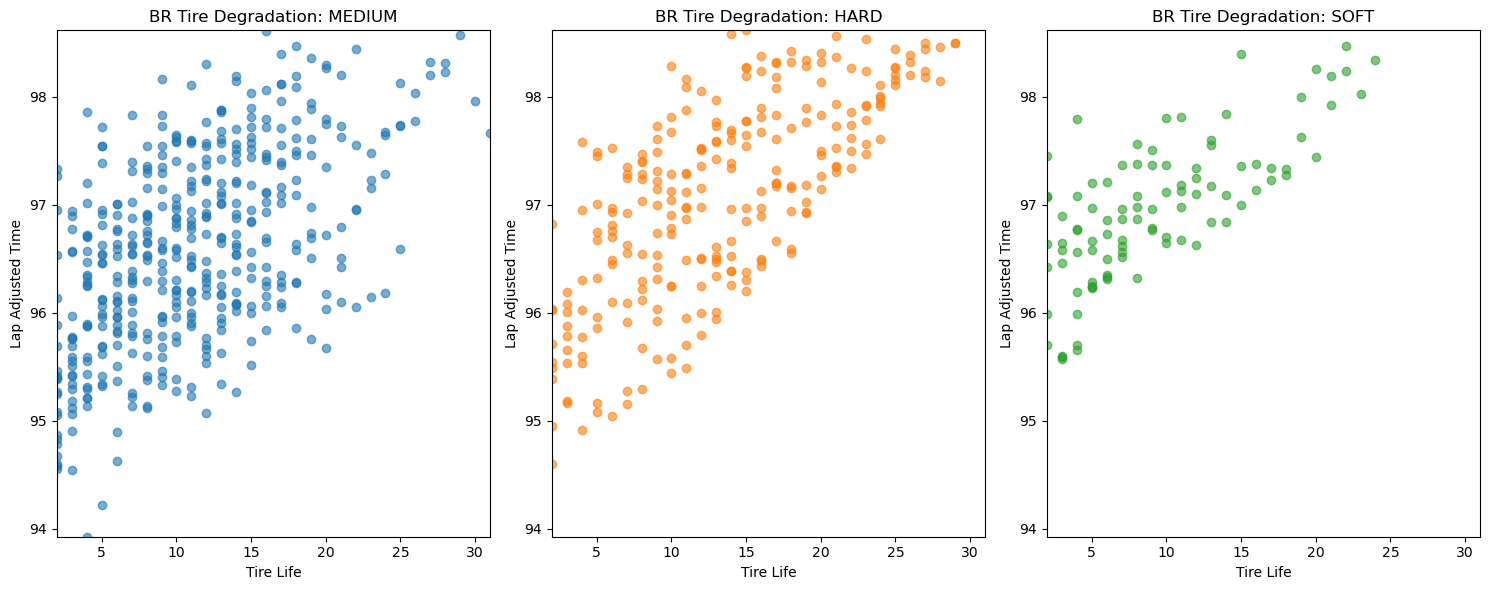

Training models for compounds: ['MEDIUM' 'HARD' 'SOFT']
Compound MEDIUM - Epoch 200, Loss: 0.6070
Compound MEDIUM - Epoch 400, Loss: 0.5648
Compound MEDIUM - Epoch 600, Loss: 0.5573
Compound MEDIUM - Epoch 800, Loss: 0.5570
Compound MEDIUM - Epoch 1000, Loss: 0.5569
Compound HARD - Epoch 200, Loss: 0.4653
Compound HARD - Epoch 400, Loss: 0.4252
Compound HARD - Epoch 600, Loss: 0.4253
Compound HARD - Epoch 800, Loss: 0.4284
Compound HARD - Epoch 1000, Loss: 0.4254
Compound SOFT - Epoch 200, Loss: 0.2908
Compound SOFT - Epoch 400, Loss: 0.2419
Compound SOFT - Epoch 600, Loss: 0.2074
Compound SOFT - Epoch 800, Loss: 0.1942
Compound SOFT - Epoch 1000, Loss: 0.1942


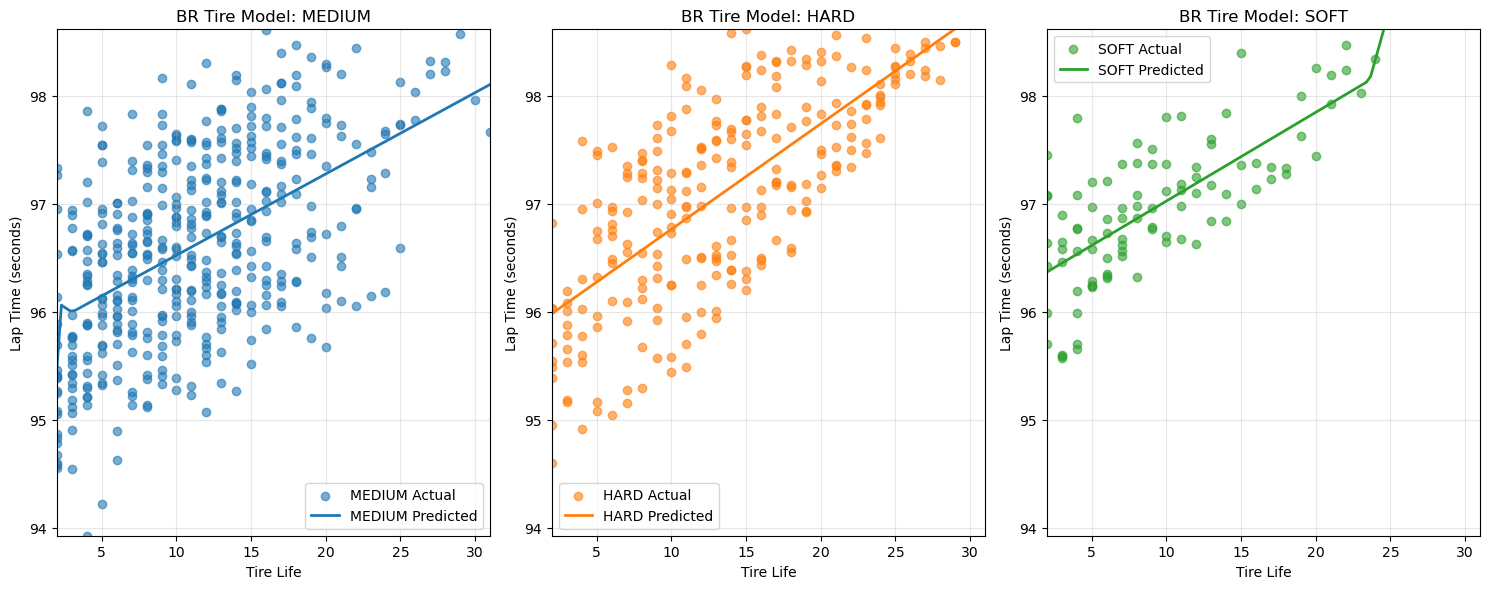

Using pit stop time penalty for BR: 25.27s

=== BR RACE STRATEGY OPTIMIZATION ===

Evaluating strategies with 0 pit stops...
  No stops with MEDIUM: 6007.25s (01:40:07.254)
  New best strategy found: 6007.25s (01:40:07.254)
  No stops with HARD: 6417.89s (01:46:57.887)
  No stops with SOFT: 6558.61s (01:49:18.608)

Evaluating strategies with 1 pit stops...
  Found better strategy: [30], ['MEDIUM', 'MEDIUM'], 5522.23s (01:32:02.231)
  New best strategy found: 5522.23s (01:32:02.231)

Evaluating strategies with 2 pit stops...
  Found better strategy: [20, 39], ['MEDIUM', 'MEDIUM', 'MEDIUM'], 5518.06s (01:31:58.055)
  New best strategy found: 5518.06s (01:31:58.055)

Evaluating strategies with 3 pit stops...
  Found better strategy: [15, 29, 43], ['MEDIUM', 'MEDIUM', 'MEDIUM', 'MEDIUM'], 5523.74s (01:32:03.738)

=== OPTIMAL STRATEGY FOR BR ===
Total race time: 5518.06 seconds (01:31:58.055)
Number of pit stops: 2
Pit stop laps: [20, 39]
Tire compounds: ['MEDIUM', 'MEDIUM', 'MEDIUM']

=== 

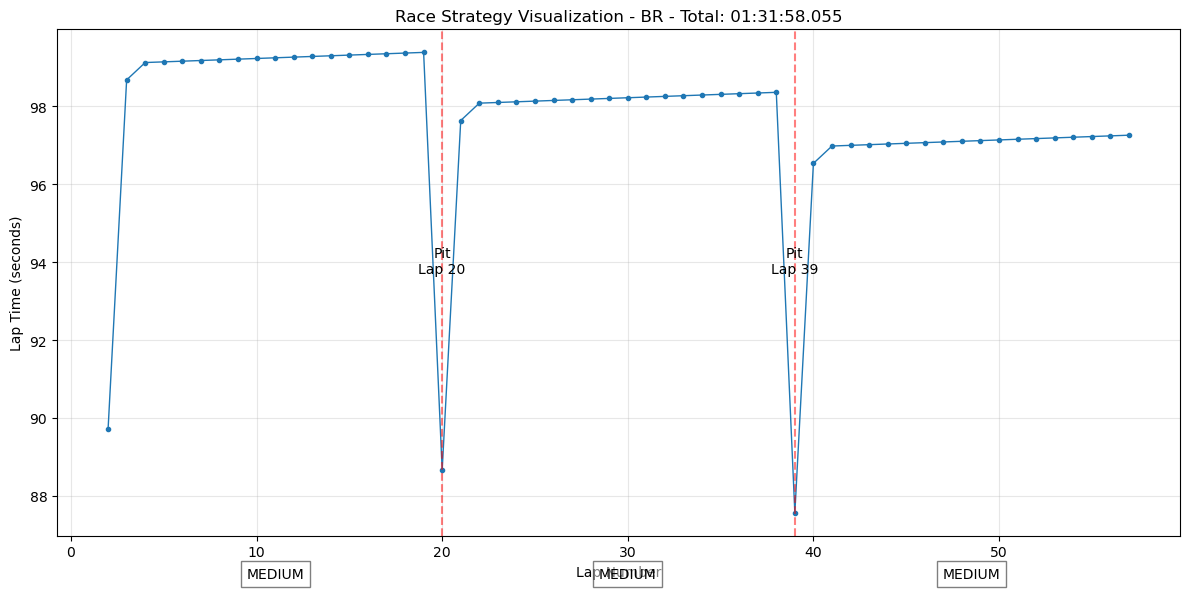

In [40]:
bahrain_result = optimize_strategy(brf, 57, 'br')

=== JR RACE STRATEGY OPTIMIZATION ===


<Figure size 1500x600 with 0 Axes>

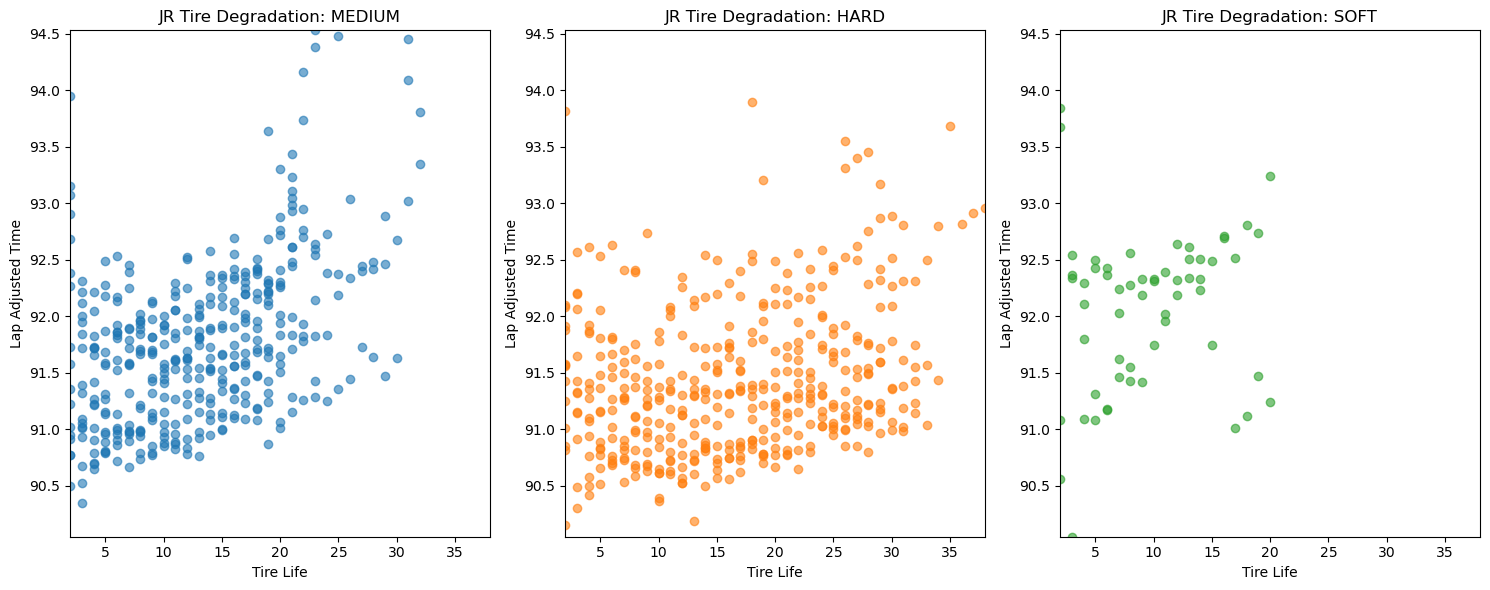

Training models for compounds: ['MEDIUM' 'HARD' 'SOFT']
Compound MEDIUM - Epoch 200, Loss: 0.4725
Compound MEDIUM - Epoch 400, Loss: 0.3902
Compound MEDIUM - Epoch 600, Loss: 0.3868
Compound MEDIUM - Epoch 800, Loss: 0.3868
Compound MEDIUM - Epoch 1000, Loss: 0.3862
Compound HARD - Epoch 200, Loss: 3.7562
Compound HARD - Epoch 400, Loss: 0.7542
Compound HARD - Epoch 600, Loss: 0.4151
Compound HARD - Epoch 800, Loss: 0.3980
Compound HARD - Epoch 1000, Loss: 0.4151
Compound SOFT - Epoch 200, Loss: 0.5526
Compound SOFT - Epoch 400, Loss: 0.4799
Compound SOFT - Epoch 600, Loss: 0.4826
Compound SOFT - Epoch 800, Loss: 0.4799
Compound SOFT - Epoch 1000, Loss: 0.4799


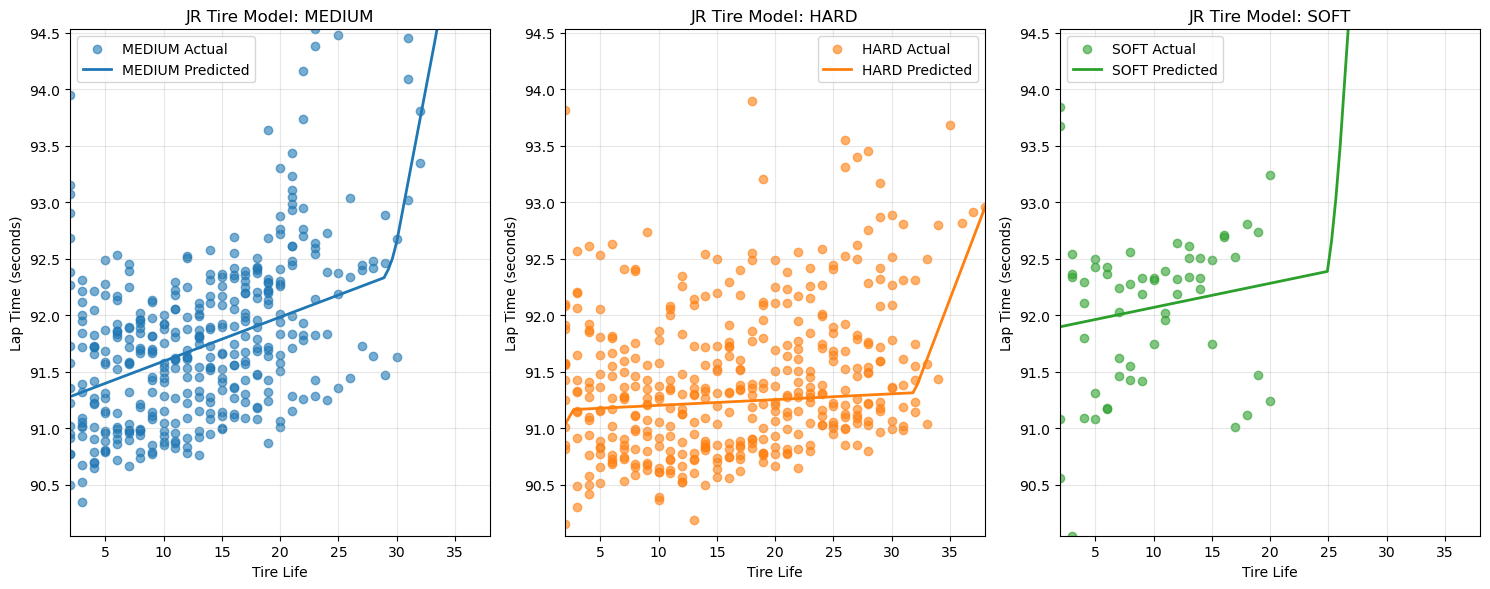

Using pit stop time penalty for JR: 23.81s

=== JR RACE STRATEGY OPTIMIZATION ===

Evaluating strategies with 0 pit stops...
  No stops with MEDIUM: 4738.19s (01:18:58.188)
  New best strategy found: 4738.19s (01:18:58.188)
  No stops with HARD: 4578.96s (01:16:18.957)
  New best strategy found: 4578.96s (01:16:18.957)
  No stops with SOFT: 5149.91s (01:25:49.910)

Evaluating strategies with 1 pit stops...
  Found better strategy: [26], ['MEDIUM', 'MEDIUM'], 4583.21s (01:16:23.212)
  Found better strategy: [18], ['MEDIUM', 'HARD'], 4557.56s (01:15:57.563)
  Found better strategy: [26], ['HARD', 'HARD'], 4543.42s (01:15:43.420)
  New best strategy found: 4543.42s (01:15:43.420)

Evaluating strategies with 2 pit stops...
  Found better strategy: [18, 34], ['MEDIUM', 'MEDIUM', 'MEDIUM'], 4591.86s (01:16:31.861)
  Found better strategy: [14, 24], ['MEDIUM', 'MEDIUM', 'HARD'], 4572.97s (01:16:12.974)
  Found better strategy: [7, 40], ['MEDIUM', 'HARD', 'MEDIUM'], 4571.88s (01:16:11.878)
  F

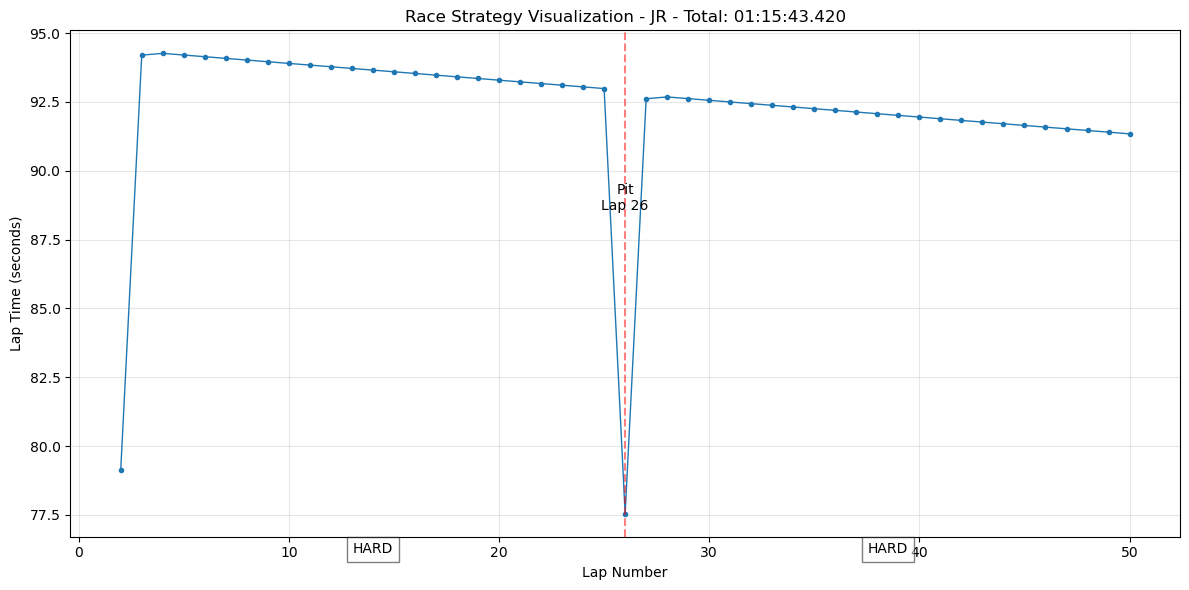

In [41]:
japan_result = optimize_strategy(jrf, 50, 'jr')

=== CR RACE STRATEGY OPTIMIZATION ===


<Figure size 1500x600 with 0 Axes>

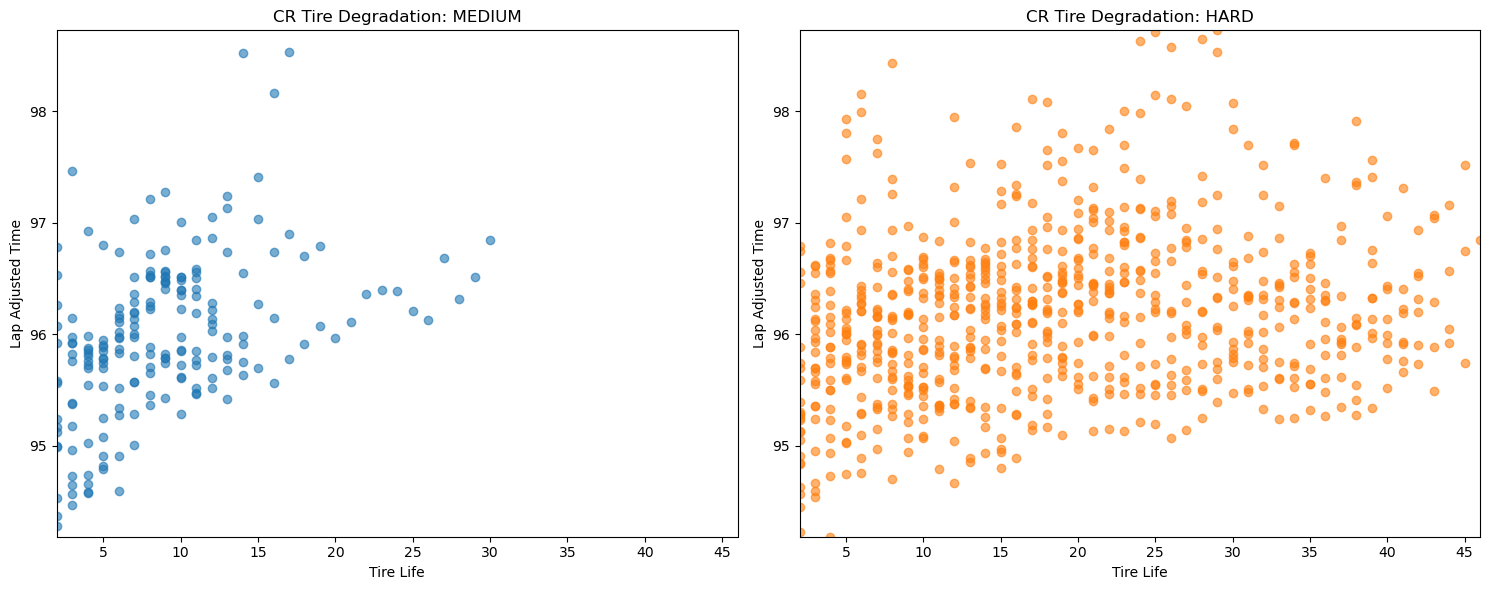

Training models for compounds: ['MEDIUM' 'HARD']
Compound MEDIUM - Epoch 200, Loss: 0.6569
Compound MEDIUM - Epoch 400, Loss: 0.3750
Compound MEDIUM - Epoch 600, Loss: 0.3729
Compound MEDIUM - Epoch 800, Loss: 0.3726
Compound MEDIUM - Epoch 1000, Loss: 0.3863
Compound HARD - Epoch 200, Loss: 1.2648
Compound HARD - Epoch 400, Loss: 0.5551
Compound HARD - Epoch 600, Loss: 0.5012
Compound HARD - Epoch 800, Loss: 0.5008
Compound HARD - Epoch 1000, Loss: 0.5008


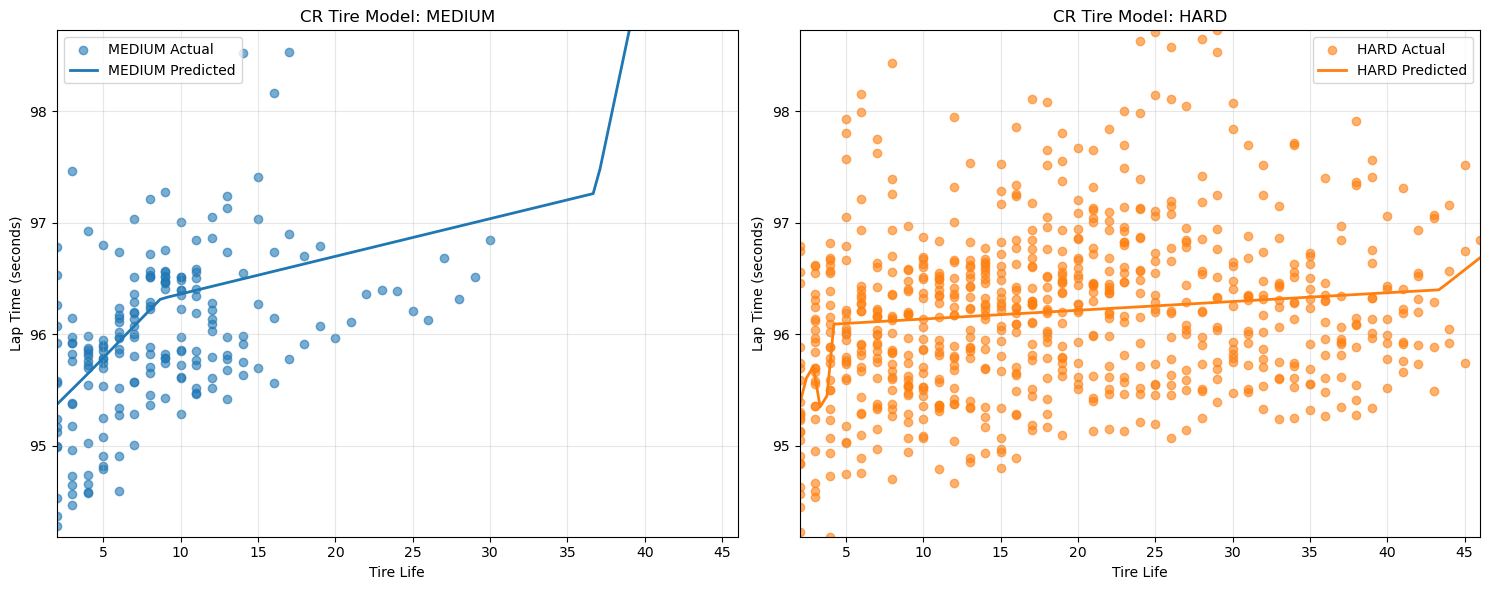

Using pit stop time penalty for CR: 23.35s

=== CR RACE STRATEGY OPTIMIZATION ===

Evaluating strategies with 0 pit stops...
  No stops with MEDIUM: 5566.20s (01:32:46.198)
  New best strategy found: 5566.20s (01:32:46.198)
  No stops with HARD: 5393.57s (01:29:53.567)
  New best strategy found: 5393.57s (01:29:53.567)

Evaluating strategies with 1 pit stops...
  Found better strategy: [29], ['MEDIUM', 'MEDIUM'], 5394.59s (01:29:54.593)
  Found better strategy: [19], ['MEDIUM', 'HARD'], 5390.86s (01:29:50.860)
  New best strategy found: 5390.86s (01:29:50.860)

Evaluating strategies with 2 pit stops...
  Found better strategy: [20, 38], ['MEDIUM', 'MEDIUM', 'MEDIUM'], 5395.78s (01:29:55.775)

Evaluating strategies with 3 pit stops...
  Found better strategy: [15, 28, 42], ['MEDIUM', 'MEDIUM', 'MEDIUM', 'MEDIUM'], 5401.24s (01:30:01.243)

=== OPTIMAL STRATEGY FOR CR ===
Total race time: 5390.86 seconds (01:29:50.860)
Number of pit stops: 1
Pit stop laps: [19]
Tire compounds: ['MEDIUM', 

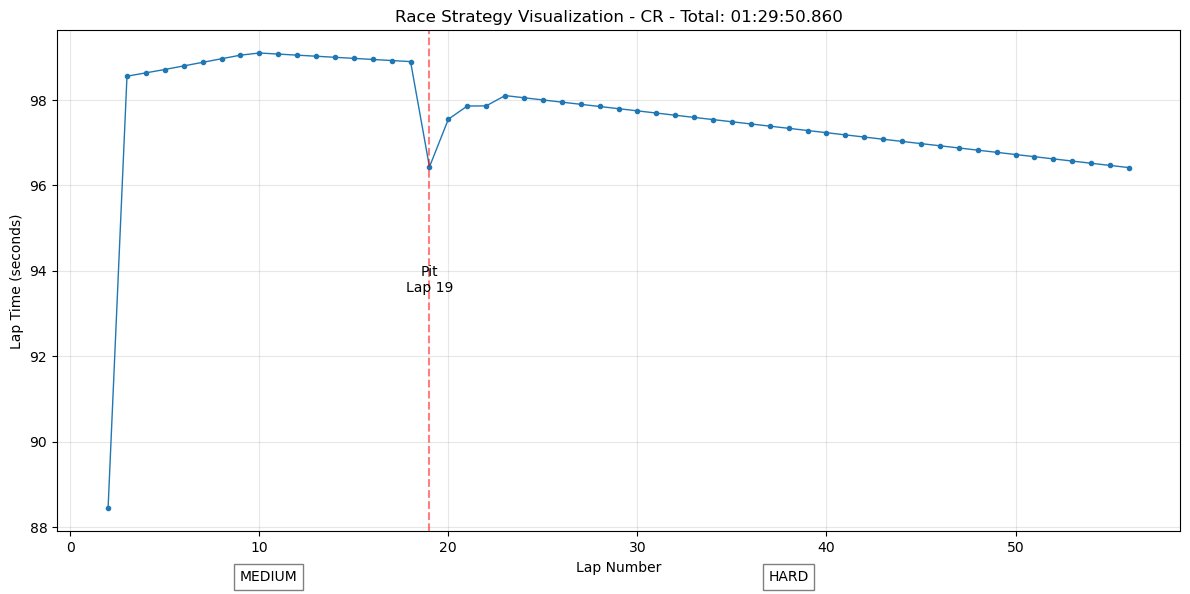

In [42]:
china_result = optimize_strategy(crf, 56, 'cr')